Ref: [Game of Deep Learning: Ship datasets](https://www.kaggle.com/arpitjain007/game-of-deep-learning-ship-datasets/notebooks)
* [Ship Classification - Top 3.3 % Kernel](https://www.kaggle.com/sandeeppat/ship-classification-top-3-5-kernel)
* [AV-game of deep learning](https://www.kaggle.com/narendrashu/av-game-of-deep-learning)

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import torchvision.models as models

# 1. สำรวจข้อมูล

**1) โครงสร้างไฟล์** 

* ship-balance
    * train
        * 2870024.jpg ...
    * test
        * 2868091.jpg ...
    * train.csv
    * test.csv
    
**2) ข้อมูล train.csv** 

In [46]:
train_df = pd.read_csv('C:/Users/NCC/Desktop/thesis/dataset/ship-unbalance/train.csv')

In [45]:
convertlabeldict = {1: 'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}
train_df['category_label'] = train_df['category'].map(convertlabeldict)
train_df.shape

(6252, 3)

In [44]:
train_df.head()

,image,category,category_label
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [4]:
train_df.groupby('category').count()

,image
category,
1,2120
2,1167
3,916
4,832
5,1217


<AxesSubplot:xlabel='category', ylabel='count'>

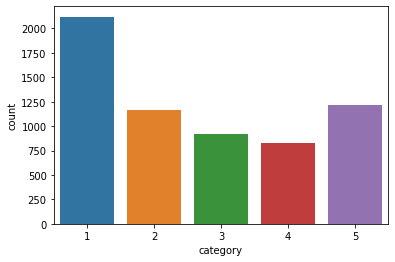

In [5]:
sns.countplot(x='category' , data=train_df)

**3) ข้อมูลรูปภาพใน train** 

In [7]:
# Read images according to train.csv

train_images=[]

for i in range(len(train_df)):
    img = os.path.join("C:/Users/NCC/Desktop/thesis/dataset/ship-unbalance/train/", train_df.image[i])
    img = cv2.imread(img)
    train_images.append(img)

print("Number of train images =", len(train_images))
print("Shape of an images =", train_images[99].shape)

Number of train images = 6252
Shape of an images = (140, 210, 3)


In [49]:
fetch = train_df.loc[train_df['category']==category['Cargo']][:5]
fetch = train_df

Categoty: Cargo


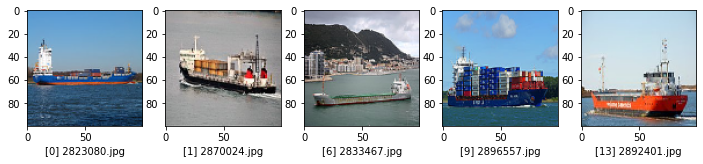

Categoty: Military


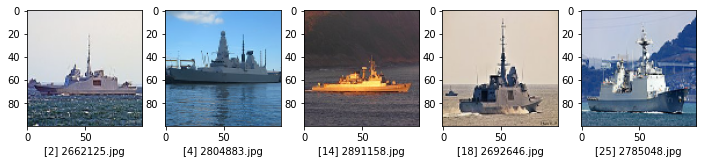

Categoty: Carrier


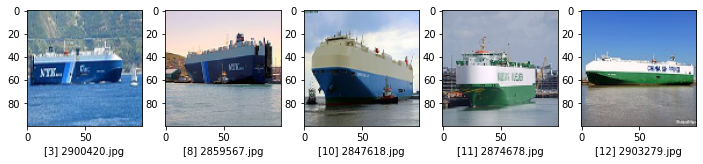

Categoty: Cruise


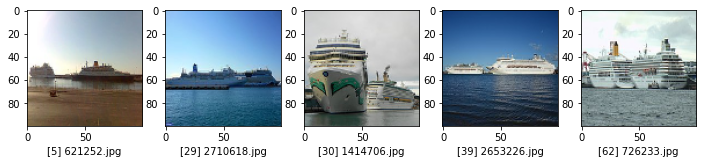

Categoty: Tankers


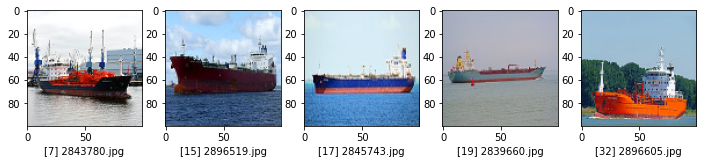

In [51]:
# Show images from each category

category = {'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

for cat in category:
    fetch = train_df.loc[train_df['category']==category[cat]][:5]
    fig = plt.figure(figsize=(12,7))

    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,5,i)
        img = train_images[index]
        img = cv2.resize(img, (100, 100))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xlabel("["+str(index)+"] "+str(fetch.image[index]))
        
    print("Categoty:",cat)
    plt.show()

# 2. เตรียมข้อมูล

In [52]:
path = Path('C:/Users/NCC/Desktop/thesis/dataset/ship-unbalance')

tfms = aug_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10.0, 
                      max_zoom=1.22, 
                      max_lighting=0.22, 
                      max_warp=0.0, 
                      p_affine=0.75,
                      p_lighting=0.75)

dls = ImageDataLoaders.from_csv(path, 
                                 folder='train', 
                                 csv_fname='train.csv',
                                 valid_pct=0.2,
                                 seed=42, 
                                 item_tfms=Resize(128), 
                                 batch_tfms=tfms, 
                                 num_workers=0)

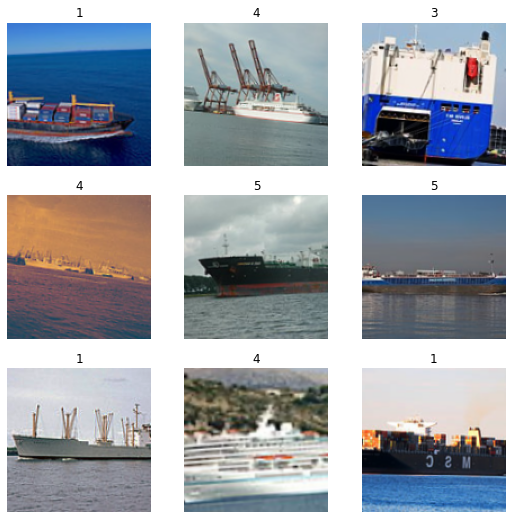

In [10]:
dls.show_batch()

# 3. สร้างโมเดลและเทรน

In [11]:
learn = cnn_learner(dls,
                    xresnet18, 
                    normalize=True, 
                    pretrained=True,
                    metrics=[error_rate, accuracy])

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=1.5848931980144698e-06)

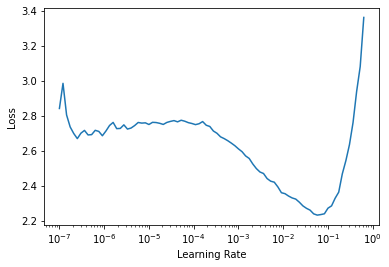

In [12]:
learn.lr_find()

In [13]:
print("Optimizer...")
learn.recorder.opt_func

Optimizer...


<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [14]:
print("Loss Function...")
learn.recorder.loss_func

Loss Function...


FlattenedLoss of CrossEntropyLoss()

In [15]:
lr = 5e-3
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.733894,1.105184,0.408000,0.592000,00:21
1,1.323903,1.063680,0.386400,0.613600,00:20
2,1.090348,0.863443,0.352000,0.648000,00:20
3,0.978643,0.800426,0.311200,0.688800,00:20
4,0.874040,0.737669,0.288000,0.712000,00:20
5,0.797005,0.740953,0.288800,0.711200,00:20
6,0.714838,0.631984,0.238400,0.761600,00:20
7,0.655433,0.598921,0.245600,0.754400,00:20
8,0.627044,0.584327,0.236800,0.763200,00:20
9,0.604590,0.576137,0.230400,0.769600,00:20


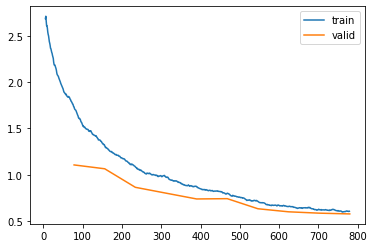

In [16]:
learn.recorder.plot_loss()

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

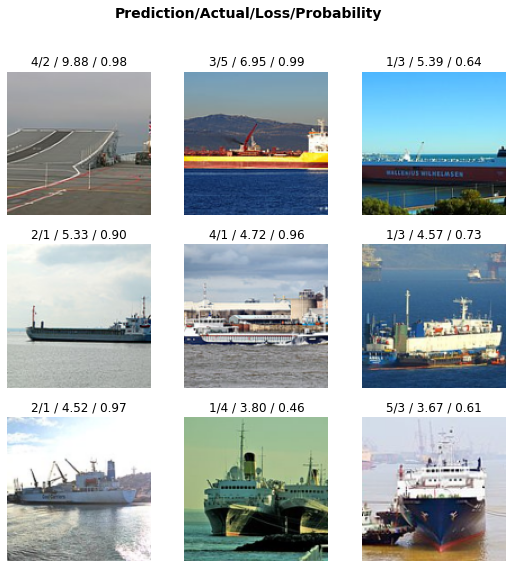

In [18]:
interp.plot_top_losses(9)

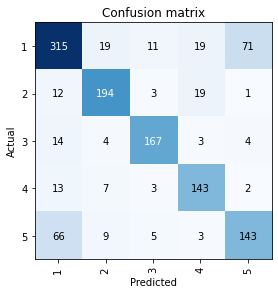

In [19]:
interp.plot_confusion_matrix(title='Confusion matrix')

In [20]:
interp.print_classification_report()

              precision    recall  f1-score   support

           1       0.75      0.72      0.74       435
           2       0.83      0.85      0.84       229
           3       0.88      0.87      0.88       192
           4       0.76      0.85      0.81       168
           5       0.65      0.63      0.64       226

    accuracy                           0.77      1250
   macro avg       0.78      0.79      0.78      1250
weighted avg       0.77      0.77      0.77      1250



# 4. เทรนอีกรอบแบบ unfreeze

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=3.981071586167673e-06)

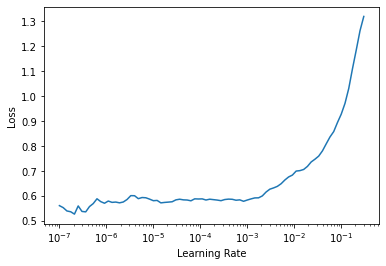

In [22]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(10, lr_max=slice(1e-7, 3e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.480102,0.525853,0.200800,0.799200,00:21
1,0.504295,0.593298,0.223200,0.776800,00:21
2,0.526854,0.567003,0.211200,0.788800,00:21
3,0.530940,0.603600,0.209600,0.790400,00:21
4,0.505955,0.565008,0.214400,0.785600,00:21
5,0.503367,0.562446,0.212000,0.788000,00:21
6,0.495574,0.544601,0.197600,0.802400,00:21
7,0.464335,0.531233,0.200000,0.800000,00:21
8,0.450831,0.533068,0.197600,0.802400,00:21
9,0.439899,0.532264,0.196800,0.803200,00:21


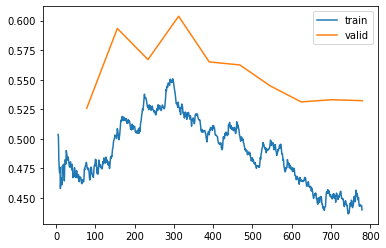

In [31]:
learn.recorder.plot_loss()

In [32]:
interp1 = ClassificationInterpretation.from_learner(learn)

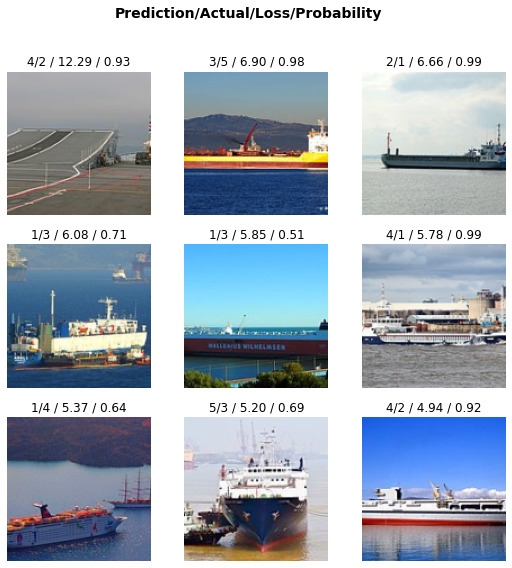

In [33]:
interp1.plot_top_losses(9)

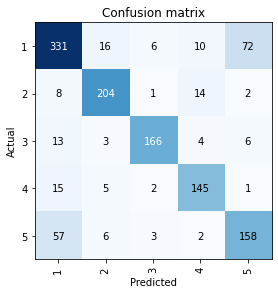

In [34]:
interp1.plot_confusion_matrix(title='Confusion matrix')

In [35]:
interp1.print_classification_report()

              precision    recall  f1-score   support

           1       0.78      0.76      0.77       435
           2       0.87      0.89      0.88       229
           3       0.93      0.86      0.90       192
           4       0.83      0.86      0.85       168
           5       0.66      0.70      0.68       226

    accuracy                           0.80      1250
   macro avg       0.81      0.82      0.81      1250
weighted avg       0.81      0.80      0.80      1250

